In [2]:
import yfinance as yf # yfiance can also directly be used to get data
import datetime
import pandas as pd
import matplotlib as plt
import numpy as np

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix

ModuleNotFoundError: No module named 'codelib'

## Adjusted Stock Prices

[*********************100%***********************]  6 of 6 completed


Text(0.5, 1.0, 'Normalized Price Performance of Selected Assets')

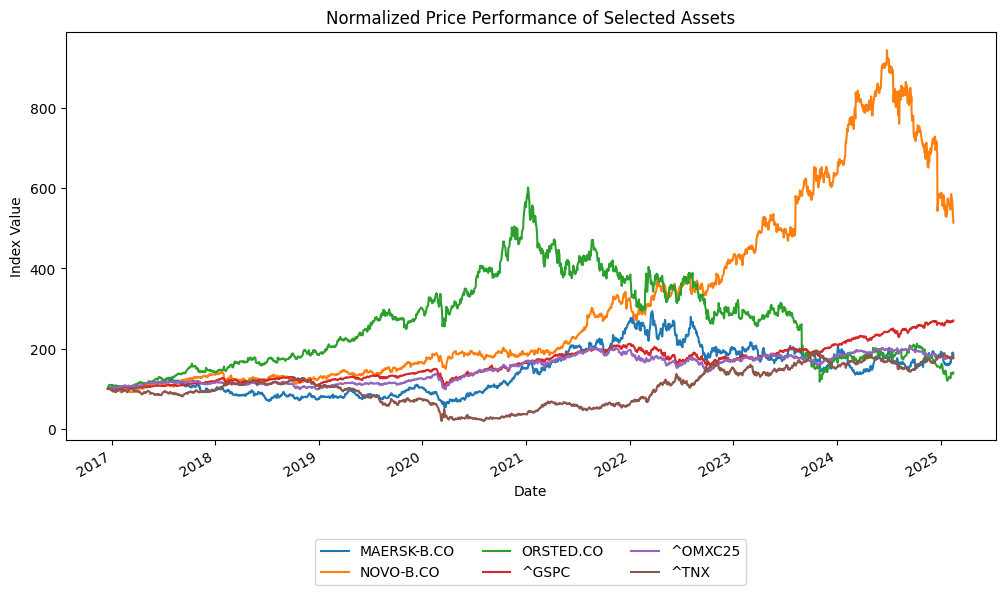

In [36]:
# Define the tickers
tickers = [
    "^TNX",        # US Treasury Bond Returns (10-Year Yield)
    "^GSPC",       # S&P 500 Index
    "MAERSK-B.CO",        # Maersk
    "ORSTED.CO",   # Ørsted
    "NOVO-B.CO",   # Novo Nordisk
    #BTC-USD",  # iShares Bitcoin ETF (if available, otherwise use BITO)
    "^OMXC25"      # OMX Copenhagen 25 Index
]

# Download historical data
data = yf.download(tickers, start=datetime.date(2013,1,1), auto_adjust=False)

# Get close prices and normalize
close_prices = data['Adj Close'].dropna()   #Removing dates with missing value
normalized_prices = close_prices / close_prices.iloc[0, :] * 100

# Plot the normalized prices
ax = normalized_prices.plot(figsize=(12, 6))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3)  # Adjust legend position
ax.set_ylabel('Index Value') #Normalized to 100
ax.set_title('Normalized Price Performance of Selected Assets')

In [37]:
normalized_prices_adj_log_ret = np.log(normalized_prices / normalized_prices.shift(1)).dropna()

In [38]:
normalized_prices_adj_log_ret.tail()

Ticker,MAERSK-B.CO,NOVO-B.CO,ORSTED.CO,^GSPC,^OMXC25,^TNX
Date,,,,,,
2025-02-10,0.029684,-0.021700,0.001674,0.006690,-0.002909,0.001336
2025-02-11,0.060903,-0.025010,0.004007,0.000340,0.005274,0.009745
2025-02-12,-0.023752,-0.024455,-0.026677,-0.002728,-0.006692,0.021802
2025-02-13,-0.023906,-0.034214,0.017639,0.010372,0.003651,-0.024450
2025-02-14,0.026802,-0.015132,0.011368,-0.000072,-0.000704,-0.011782



We want to specify an exponential filter to estimate the covariance matrix. To that end, we define ($\mathbf{x}_t$ is the return vector at time $t$)

$$
\boldsymbol{\mu}^{\lambda}_{T+1} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t
$$

and 

$$
\boldsymbol{\Sigma}^{\lambda}_{T+1} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t \mathbf{x}_t^\top  - \boldsymbol{\mu}^{\lambda}_{T+1} (\boldsymbol{\mu}^{\lambda}_{T+1})^\top
$$

where $\gamma = 1 /  \sum_{t=1}^T e^{-\lambda (T-t)}$ to make the weights sum to one. $\lambda$ controls the decay of the exponential filter. A $\lambda=0.0055$ will represent a half-life of approximately six months with daily data. 

Implement the exponential filter and apply it with $\lambda=0.0055$ 


In [39]:
data = normalized_prices_adj_log_ret.values

def covariance_exponential_filter(data, decay=0.0055, zero_mean=False): 
    
    data_out = np.einsum('ji,jk->jik', data, data)
    T = len(data)
    cov_matrices = list()
    mu_est = np.zeros_like(data.shape[1])
    
    for t in np.arange(1, T+1):

        tp = np.arange(0, t)
        weights = np.flip(np.exp(-decay * tp))
        sum_weights = np.sum(weights)
        
        if ~zero_mean:
            mu_est = np.sum(data[:t, :] * weights[:, None], axis=0) / sum_weights
        
        cov_est =   np.sum(data_out[:t, :, :] * weights[:, None, None] / sum_weights, axis=0) - np.outer(mu_est, mu_est)
    
        cov_matrices.append(cov_est)
        
    cov_matrices = np.array(cov_matrices)
    
    return cov_matrices


cov_matrices = covariance_exponential_filter(data, decay=0.0055, zero_mean=True)
corr_matrices = np.array([cov_to_corr_matrix(cov_matrices[i]) for i in range(1, len(cov_matrices))])

C:\Users\admin\AppData\Local\Temp\ipykernel_8312\3029144020.py:16: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  if ~zero_mean:


NameError: name 'cov_to_corr_matrix' is not defined

Plot the variance of Facebook. 

Plot the correlation between Facebook and all the other stocks over the time period. 


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(faang_adj_log_ret.index[1:, ], np.sqrt(cov_matrices[1:, 0, 0] * 250));
ax.set_title("Facebook's volatility seems to be time varying");
ax.set_ylabel("Volatility (annualized)");

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
for i in range(5):
    ax.plot(faang_adj_log_ret.index[2:, ], corr_matrices[1:, 0, i], label=tickers[i]);

ax.set_title("Facebook's correlation with other FAANG stocks");
ax.set_ylabel("Volatility (annualized)");
ax.legend()
ax.set_ylim([-1.0, 1.05]);